In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import sklearn
pd.set_option('use_inf_as_na', True)
from collections import Counter

In [57]:
raw_data = pd.read_pickle(r'C:\Users\niels\OneDrive\Machine Learning 2022\Lecture 2\dataset.pkl')
data = raw_data[raw_data['market_cap'] > 1000.0]
data = data.copy()
data.fillna(0.0,inplace=True)

In [58]:
def f(x):
    if x > 0.01:
        return 1
    elif x < -0.025:
        return -1
    else:
    
        return 0

In [59]:
data['rel_performance'] = data['pred_rel_return'].apply(f)
data.reset_index(inplace=True)
data.set_index('date',inplace=True)

In [60]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = StandardScaler()

## Long term performance with Random Forest Classifier, optimal hyper-parameters

In [61]:
start_dates = [pd.to_datetime('2001-01-01') + pd.DateOffset(months = 3*i) for i in range(57)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

In [62]:
training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
valid_frames = [data.loc[d:d+pd.DateOffset(months = 3)] for d in end_dates]
test_frames = [data.loc[d+pd.DateOffset(months = 6):d+pd.DateOffset(months = 9)] for d in end_dates]

In [63]:
training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]

In [64]:
valid_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in valid_frames]

In [65]:
test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

In [66]:
training_labels = [d['rel_performance'].values for d in training_frames]
valid_labels = [d['rel_performance'].values for d in valid_frames] 

In [67]:
for i in range(len(start_dates)-1):
    float_vars = [x for x in training_data[i].columns if data[x].dtype == 'float64']

    scaler = StandardScaler()
    training_data[i] = training_data[i].copy()
    valid_data[i] = valid_data[i].copy()
    test_data[i] = test_data[i].copy()
    training_data[i][float_vars] = scaler.fit_transform(training_data[i][float_vars])
    valid_data[i][float_vars] = scaler.transform(valid_data[i][float_vars])
    test_data[i][float_vars] = scaler.transform(test_data[i][float_vars])
        
    

In [ ]:
import optuna
from optuna.trial import Trial
optuna.logging.set_verbosity(optuna.logging.FATAL)
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def objective(trial:Trial,train=None,labels=None,val=None,val_labels=None,val_rets=None):

    ada_m_depth = trial.suggest_int('max_depth',1,3,step=1)
    ada_n_estimators = trial.suggest_int('n_estimators', 10,100,step=10)
    ada_learning_rate = trial.suggest_float('learning_rate',0.1,0.5, step=0.1)

    
    ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=ada_m_depth),
                                 n_estimators=ada_n_estimators,
                                 learning_rate=ada_learning_rate,
                                 algorithm="SAMME.R")

    ada_clf.fit(train,labels)
    preds = ada_clf.predict(val)
    accuracy = ada_clf.score(val,val_labels)
 
    return accuracy


In [ ]:
optimal_hyperparameters = []

In [ ]:
from functools import partial

In [ ]:
for i in range(len(start_dates)-1):
    
    study = optuna.create_study(direction="maximize")
    
    study.optimize(partial(objective,
                           train=training_data[i],
                           labels=training_labels[i],
                           val=valid_data[i],
                           val_labels=valid_labels[i],
                           val_rets=valid_frames[i]['next_period_return']), n_trials=25,n_jobs=-1)
    
    optimal_hyperparameters.append(study.best_params)  
    print(study.best_params)
    

In [14]:
import pickle

In [ ]:
with open(r'optimal_hyperparameters_ada_01.pkl','wb') as f:
    pickle.dump(optimal_hyperparameters,f)

In [15]:
with open(r'optimal_hyperparameters_ada_01.pkl','rb') as f:
    optimal_hyperparameters = pickle.load(f)

In [16]:
optimal_hyperparameters

[{'max_depth': 3, 'n_estimators': 70, 'learning_rate': 0.5},
 {'max_depth': 3, 'n_estimators': 10, 'learning_rate': 0.5},
 {'max_depth': 2, 'n_estimators': 70, 'learning_rate': 0.4},
 {'max_depth': 3, 'n_estimators': 20, 'learning_rate': 0.1},
 {'max_depth': 2, 'n_estimators': 90, 'learning_rate': 0.5},
 {'max_depth': 1, 'n_estimators': 10, 'learning_rate': 0.5},
 {'max_depth': 2, 'n_estimators': 80, 'learning_rate': 0.5},
 {'max_depth': 1, 'n_estimators': 70, 'learning_rate': 0.5},
 {'max_depth': 1, 'n_estimators': 30, 'learning_rate': 0.5},
 {'max_depth': 3, 'n_estimators': 60, 'learning_rate': 0.30000000000000004},
 {'max_depth': 1, 'n_estimators': 30, 'learning_rate': 0.2},
 {'max_depth': 3, 'n_estimators': 10, 'learning_rate': 0.2},
 {'max_depth': 3, 'n_estimators': 10, 'learning_rate': 0.4},
 {'max_depth': 2, 'n_estimators': 40, 'learning_rate': 0.5},
 {'max_depth': 2, 'n_estimators': 100, 'learning_rate': 0.2},
 {'max_depth': 2, 'n_estimators': 100, 'learning_rate': 0.5},
 {'max

In [68]:
classifiers = []

In [69]:
for hyp_par in optimal_hyperparameters:
    max_depth = hyp_par['max_depth']
    n_estimators = hyp_par['n_estimators']
    learning_rate = hyp_par['learning_rate']
    ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth),n_estimators=n_estimators,learning_rate=learning_rate)
    classifiers.append(ada_clf)

In [70]:
for i in range(len(start_dates)-1): 
    classifiers[i].fit(training_data[i],training_labels[i])

KeyboardInterrupt: 

In [ ]:
with open(r'classifiers_ada_01.pkl','wb') as f:
    pickle.dump(classifiers,f)

In [94]:
with open(r'classifiers_ada_01.pkl','rb') as f:
    classifiers = pickle.load(f)

In [95]:
def adaboost_feat_importances(m, df):
        
    return pd.DataFrame({'cols':df.columns, 'feat_imp': m.feature_importances_}
                       ).sort_values('feat_imp', ascending=False)

In [123]:
significant_features = []

In [124]:
%%time

for i in range(len(start_dates)-1):

    fi = adaboost_feat_importances(classifiers[i],training_data[i])
    features = fi[fi['feat_imp'] > 0.016]
    significant_features.append(features)

CPU times: total: 62.5 ms
Wall time: 124 ms


In [127]:
significant_features[0]

,cols,feat_imp
87,prccq,0.018722
92,market_cap,0.017826
172,pay_turnq,0.017298
77,oepsxy,0.017138
135,pretret_earnatq,0.017004


In [128]:
with open(r'significant_features_ada_02.pkl','wb') as f:
    pickle.dump(significant_features,f)

In [129]:
with open(r'significant_features_ada_02.pkl','rb') as f:
    significant_features = pickle.load(f)

In [130]:
new_training_data = []
new_valid_data = []
new_test_data = []

In [131]:
for i in range(len(start_dates)-1): 
    new_training_data.append(training_data[i][significant_features[i]['cols']])
    new_valid_data.append(valid_data[i][significant_features[i]['cols']])
    new_test_data.append(test_data[i][significant_features[i]['cols']])
    

In [132]:
for i in range(len(start_dates)-1):
    float_vars = [x for x in new_training_data[i].columns if data[x].dtype == 'float64']

    scaler = StandardScaler()
    new_training_data[i] = new_training_data[i].copy()
    new_valid_data[i] = new_valid_data[i].copy()
    new_test_data[i] = new_test_data[i].copy()
    new_training_data[i][float_vars] = scaler.fit_transform(new_training_data[i][float_vars])
    new_valid_data[i][float_vars] = scaler.transform(new_valid_data[i][float_vars])
    new_test_data[i][float_vars] = scaler.transform(new_test_data[i][float_vars])

In [133]:
for i in range(len(start_dates)-1): 
    classifiers[i].fit(new_training_data[i],training_labels[i])

In [134]:
with open(r'new_classifiers_ada_02.pkl','wb') as f:
    pickle.dump(classifiers,f)

In [135]:
def model(features):
    tree_features = features[features.columns[:-1].values]

    pred = ada_clf.predict(tree_features)

    ret = pred * features[features.columns[-1]]

    return ret

In [136]:
import shap

In [137]:
shap_features = []

In [138]:
for i in range(len(start_dates)-1):
    valid_1 = new_valid_data[i].copy()
    cols = new_valid_data[i].columns
    print(len(cols))
    valid_1['rets'] = valid_frames[i]['next_period_return'].values
    ada_clf = classifiers[i]
    explainer = shap.explainers.Permutation(model,valid_1)
    shap_values = explainer(valid_1,max_evals=500,)
    shap_cols = cols[np.abs(shap_values[:,:-1].values).mean(axis=0)>0.000]
    if shap_cols.empty:
        shap_cols = cols
    print(len(shap_cols))
    shap_features.append(shap_cols)
    

5


Permutation explainer: 1123it [17:13,  1.07it/s]                                                                       


5
26


Permutation explainer: 1156it [02:26,  7.27it/s]                                                                       


26
12


Permutation explainer: 1174it [11:52,  1.62it/s]                                                                       


12
14


Permutation explainer: 1137it [04:20,  4.22it/s]                                                                       


14
11


Permutation explainer: 1266it [17:14,  1.21it/s]                                                                       


11
10


Permutation explainer: 1261it [03:01,  6.62it/s]                                                                       


9
10


Permutation explainer: 1256it [15:17,  1.35it/s]                                                                       


10
7


Permutation explainer: 1284it [15:47,  1.34it/s]                                                                       


7
26


Permutation explainer: 1316it [07:41,  2.79it/s]                                                                       


26
9


Permutation explainer: 1414it [15:57,  1.46it/s]                                                                       


9
26


Permutation explainer: 1361it [07:52,  2.80it/s]                                                                       


26
24


Permutation explainer: 1355it [02:33,  8.19it/s]                                                                       


23
21


Permutation explainer: 1475it [03:02,  7.60it/s]                                                                       


21
16


Permutation explainer: 1512it [09:32,  2.60it/s]                                                                       


16
10


Permutation explainer: 1523it [24:41,  1.02it/s]                                                                       


10
4


Permutation explainer: 1499it [31:27,  1.27s/it]                                                                       


4
10


Permutation explainer: 1455it [20:22,  1.18it/s]                                                                       


10
10


Permutation explainer: 1400it [20:28,  1.13it/s]                                                                       


10
3


Permutation explainer: 1376it [1:04:28,  2.83s/it]                                                                     


3
20


Permutation explainer: 1301it [05:24,  3.87it/s]                                                                       


20
14


Permutation explainer: 1099it [06:38,  2.69it/s]                                                                       


14
9


Permutation explainer: 1029it [04:07,  3.98it/s]                                                                       


9
10


Permutation explainer: 1180it [10:34:59, 32.56s/it]                                                                    


10
22


Permutation explainer: 1279it [10:00,  2.09it/s]                                                                       


21
19


Permutation explainer: 1353it [03:27,  6.29it/s]                                                                       


18
21


Permutation explainer: 1442it [25:13,  1.06s/it]                                                                       


21
21


Permutation explainer: 1388it [19:31,  1.18it/s]                                                                       


21
27


Permutation explainer: 1443it [09:05,  2.61it/s]                                                                       


21
14


Permutation explainer: 1554it [03:48,  6.45it/s]                                                                       


8
3


Permutation explainer: 1547it [27:30,  1.07s/it]                                                                       


3
9


Permutation explainer: 1612it [25:01,  1.07it/s]                                                                       


9
14


Permutation explainer: 1426it [05:07,  4.47it/s]                                                                       


13
6


Permutation explainer: 1528it [21:25,  1.18it/s]                                                                       


6
7


Permutation explainer: 1610it [23:00,  1.16it/s]                                                                       


7
19


Permutation explainer: 1619it [20:12,  1.32it/s]                                                                       


19
19


Permutation explainer: 1531it [12:34,  1.99it/s]                                                                       


19
43


Permutation explainer: 1625it [19:09,  1.40it/s]                                                                       


43
18


Permutation explainer: 1751it [12:04,  2.38it/s]                                                                       


18
22


Permutation explainer: 1802it [10:01,  2.95it/s]                                                                       


22
7


Permutation explainer: 1875it [29:21,  1.06it/s]                                                                       


7
35


Permutation explainer: 1957it [11:48,  2.73it/s]                                                                       


35
5


Permutation explainer: 1969it [35:34,  1.09s/it]                                                                       


5
21


Permutation explainer: 2061it [48:48,  1.43s/it]                                                                       


21
12


Permutation explainer: 1973it [24:33,  1.33it/s]                                                                       


12
8


Permutation explainer: 2042it [09:14,  3.63it/s]                                                                       


7
12


Permutation explainer: 2081it [25:52,  1.33it/s]                                                                       


12
9


Permutation explainer: 2136it [32:57,  1.08it/s]                                                                       


9
15


Permutation explainer: 1949it [10:55,  2.92it/s]                                                                       


15
11


Permutation explainer: 1965it [13:55,  2.32it/s]                                                                       


11
11


Permutation explainer: 1951it [07:22,  4.29it/s]                                                                       


11
16


Permutation explainer: 2006it [12:16,  2.69it/s]                                                                       


16
16


Permutation explainer: 2006it [11:43,  2.81it/s]                                                                       


16
14


Permutation explainer: 2067it [26:30,  1.29it/s]                                                                       


14
8


Permutation explainer: 2109it [35:11,  1.01s/it]                                                                       


8
11


Permutation explainer: 2155it [32:54,  1.09it/s]                                                                       


11
8


Permutation explainer: 2155it [26:57,  1.32it/s]                                                                       

8


In [139]:
with open(r'shap_features_ada_02.pkl','wb') as f:
    pickle.dump(shap_features,f)

In [140]:
with open(r'shap_features_ada_02.pkl','rb') as f:
    shap_features = pickle.load(f)

In [141]:
shap_features[10]

Index(['cf_yield', 'gpmq', 'oancfy_q', 'rect_turnq', 'roceq', 'dvpspq',
       'rectq', 'ibadj12', 'rd_saleq', 'spcsrc_C', 'gprofq',
       'book_value_per_share', 'piq', 'at_turnq', 'debt_assetsq', 'de_ratioq',
       'at4', 'epsfiq', 'cash_ratioq', 'opmbdq', 'cfo-per-share',
       'buy_back_yield', 'sector_code_395.0', 'evmq', 'dprq', 'sic_1311'],
      dtype='object')

In [142]:
scalers = [StandardScaler() for i in range(len(start_dates)-1)]
           
opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features[i]].values),columns=shap_features[i]) for i in range(len(start_dates)-1)]
opt_valid_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features[i]].values),columns=shap_features[i]) for i in range(len(start_dates)-1)]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_features[i]].values),columns=shap_features[i]) for i in range(len(start_dates)-1)]

In [ ]:
opt_test_data[1]

In [143]:
x = [1]
ret = []

for i in range(len(start_dates)-1):
        
        classifiers[i].fit(opt_training_data[i],training_labels[i])

        preds = classifiers[i].predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x.append(x[i] + (x[i]/num_names)*profit_i)

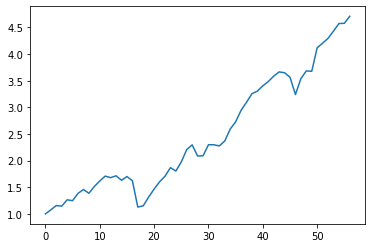

In [144]:
plt.plot(x);

In [ ]:
len(x)

In [145]:
SPY = pd.read_pickle(r'C:\Users\niels\OneDrive\Machine Learning 2022\Lecture 2\SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x

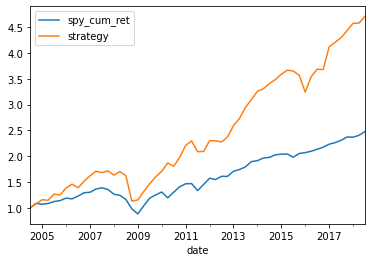

In [146]:
SPY.plot();

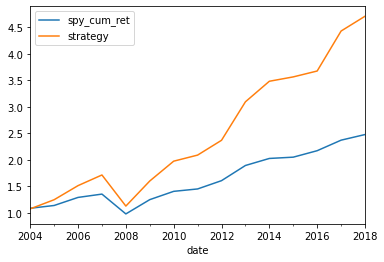

In [147]:
SPY = SPY.resample('Y').ffill()
SPY.plot();

In [148]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

Strategy Sharpe Ratio:  0.8084091791728695


In [149]:
x[-1]

4.709318095924619

In [150]:
SPY['spy_cum_ret'][-1]

2.4779340000000003

In [151]:
strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]

In [152]:
beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]

In [153]:
beta 

2.0469552618135016

In [174]:
SPY['hedge'] = SPY['strategy'] - 1.85*(SPY['spy_cum_ret']-1) 

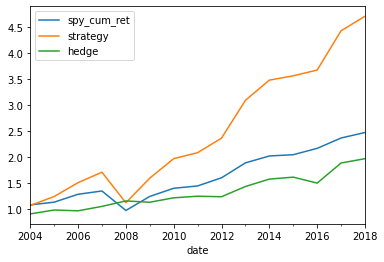

In [175]:
SPY.plot();

In [176]:
hedge_ret = (SPY['hedge'] - 1).diff().values[1:]

In [177]:
beta_hedge = (np.cov(spy_ret,hedge_ret)/np.var(spy_ret))[1,0]

In [178]:
beta_hedge

0.05464756950580973

In [179]:
hedge_mean_ret = (SPY['hedge'] - 1).diff().mean()
hedge_std = (SPY['hedge'] - 1).diff().std()
hedge_sr = hedge_mean_ret/hedge_std
print('Hedge Sharpe Ratio: ',strategy_sr)

Hedge Sharpe Ratio:  0.8084091791728695


In [54]:
IR = np.mean(residual_ret)/np.std(residual_ret)

NameError: name 'residual_ret' is not defined

In [ ]:
IR

In [ ]:
alpha = np.mean(residual_ret)

In [ ]:
alpha